## Notebook to combine the demultiplexed GEX per pool per lane anndata objects into a single anndata

- this is just to combine them not correct, see combat (old/simple), MNN, BBKNN, and scVI for that
- when loading each pool prior to combining go ahead and remove and predicted ambient RNA cells that may still after demultiplexing

In [1]:
!date

Thu Feb 22 15:12:07 EST 2024


#### import libraries and set notebook variables

In [2]:
from pandas import read_csv
from scanpy import read_h5ad
from os.path import exists
from anndata import concat as ad_concat
from seaborn import barplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
# naming
project = 'aging_phase2'
modality = 'GEX'
set_name = f'{project}_{modality}'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
demux_dir = f'{wrk_dir}/demux'
cellbender_dir = f'{wrk_dir}/cellbender'
info_dir = f'{wrk_dir}/sample_info'
quants_dir = f'{wrk_dir}/quants'

# in files
info_file = f'{info_dir}/{project}.sample_info.csv'

# out files
output_file = f'{quants_dir}/{set_name}.raw.h5ad'

# variables
DEBUG = False
lane_range = range(1, 9)

### load the sample info data

In [4]:
info_df = read_csv(info_file)
print(f'shape of info {info_df.shape}')
info_df = info_df.loc[(~info_df.gex_pool.isna()) & (~info_df.atac_pool.isna())]
print(f'shape of info {info_df.shape}')
# make sure pool nums are ints and not floats
info_df.gex_pool = info_df.gex_pool.astype('int')
info_df.atac_pool = info_df.atac_pool.astype('int')
print(f'shape of info {info_df.shape}')
if DEBUG:
    display(info_df.head())
    display(info_df.gex_pool.value_counts())

shape of info (36, 13)
shape of info (33, 13)
shape of info (33, 13)


#### combine the individual anndatas into single large anndata

In [5]:
%%time
adata_list = []

pools = set(info_df.gex_pool.unique()) | set(info_df.atac_pool.unique())

for pool in pools:
    for lane in lane_range:
        gex_pool = f'{demux_dir}/{modality}_P{pool}_{lane}.h5ad'
        if exists(gex_pool):
            this_adata = read_h5ad(gex_pool)
            cellbender_file = f'{cellbender_dir}/sample_ec_GEX_P{int(pool)}_{lane}_out_cell_barcodes.csv'
            cb_barcodes = read_csv(cellbender_file, header=None)
            this_adata = this_adata[this_adata.obs.index.isin(cb_barcodes[0])]
            if DEBUG:
                print(f'{modality}_P{pool}_{lane}: {this_adata}')
                print(f'cellbender shape {cb_barcodes.shape}')
                print(len(set(cb_barcodes[0]) & set(this_adata.obs.index))/this_adata.obs.shape[0])
            adata_list.append(this_adata)

all_adata = ad_concat(adata_list)
all_adata.obs_names_make_unique()

CPU times: user 5.74 s, sys: 2.36 s, total: 8.1 s
Wall time: 8.15 s


/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
print(all_adata)
if DEBUG:
    display(all_adata.obs.sample(10))

AnnData object with n_obs × n_vars = 126718 × 36601
    obs: 'sample_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype', 'donor_id'


#### save the combined anndata object

In [7]:
all_adata.write(output_file)

#### visualization functions

In [8]:
# function to plot the barcode counts by sample
def plot_sample_barcode_counts(this_df, sample_name, id_col='sample_id'):
    with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 100}):
        plt.style.use('seaborn-v0_8-talk')
        barplot(x=this_df[id_col].value_counts().index,
                y=this_df[id_col].value_counts().values,
                order=this_df[id_col].value_counts().index,
                palette='Blues_d')
        plt.xticks(rotation=90, fontsize=8)
        plt.tight_layout()
        plt.title(sample_name)
        plt.ylabel('barcode counts')
        plt.show()
    print(this_df[id_col].value_counts())

#### visualize the counts by sample

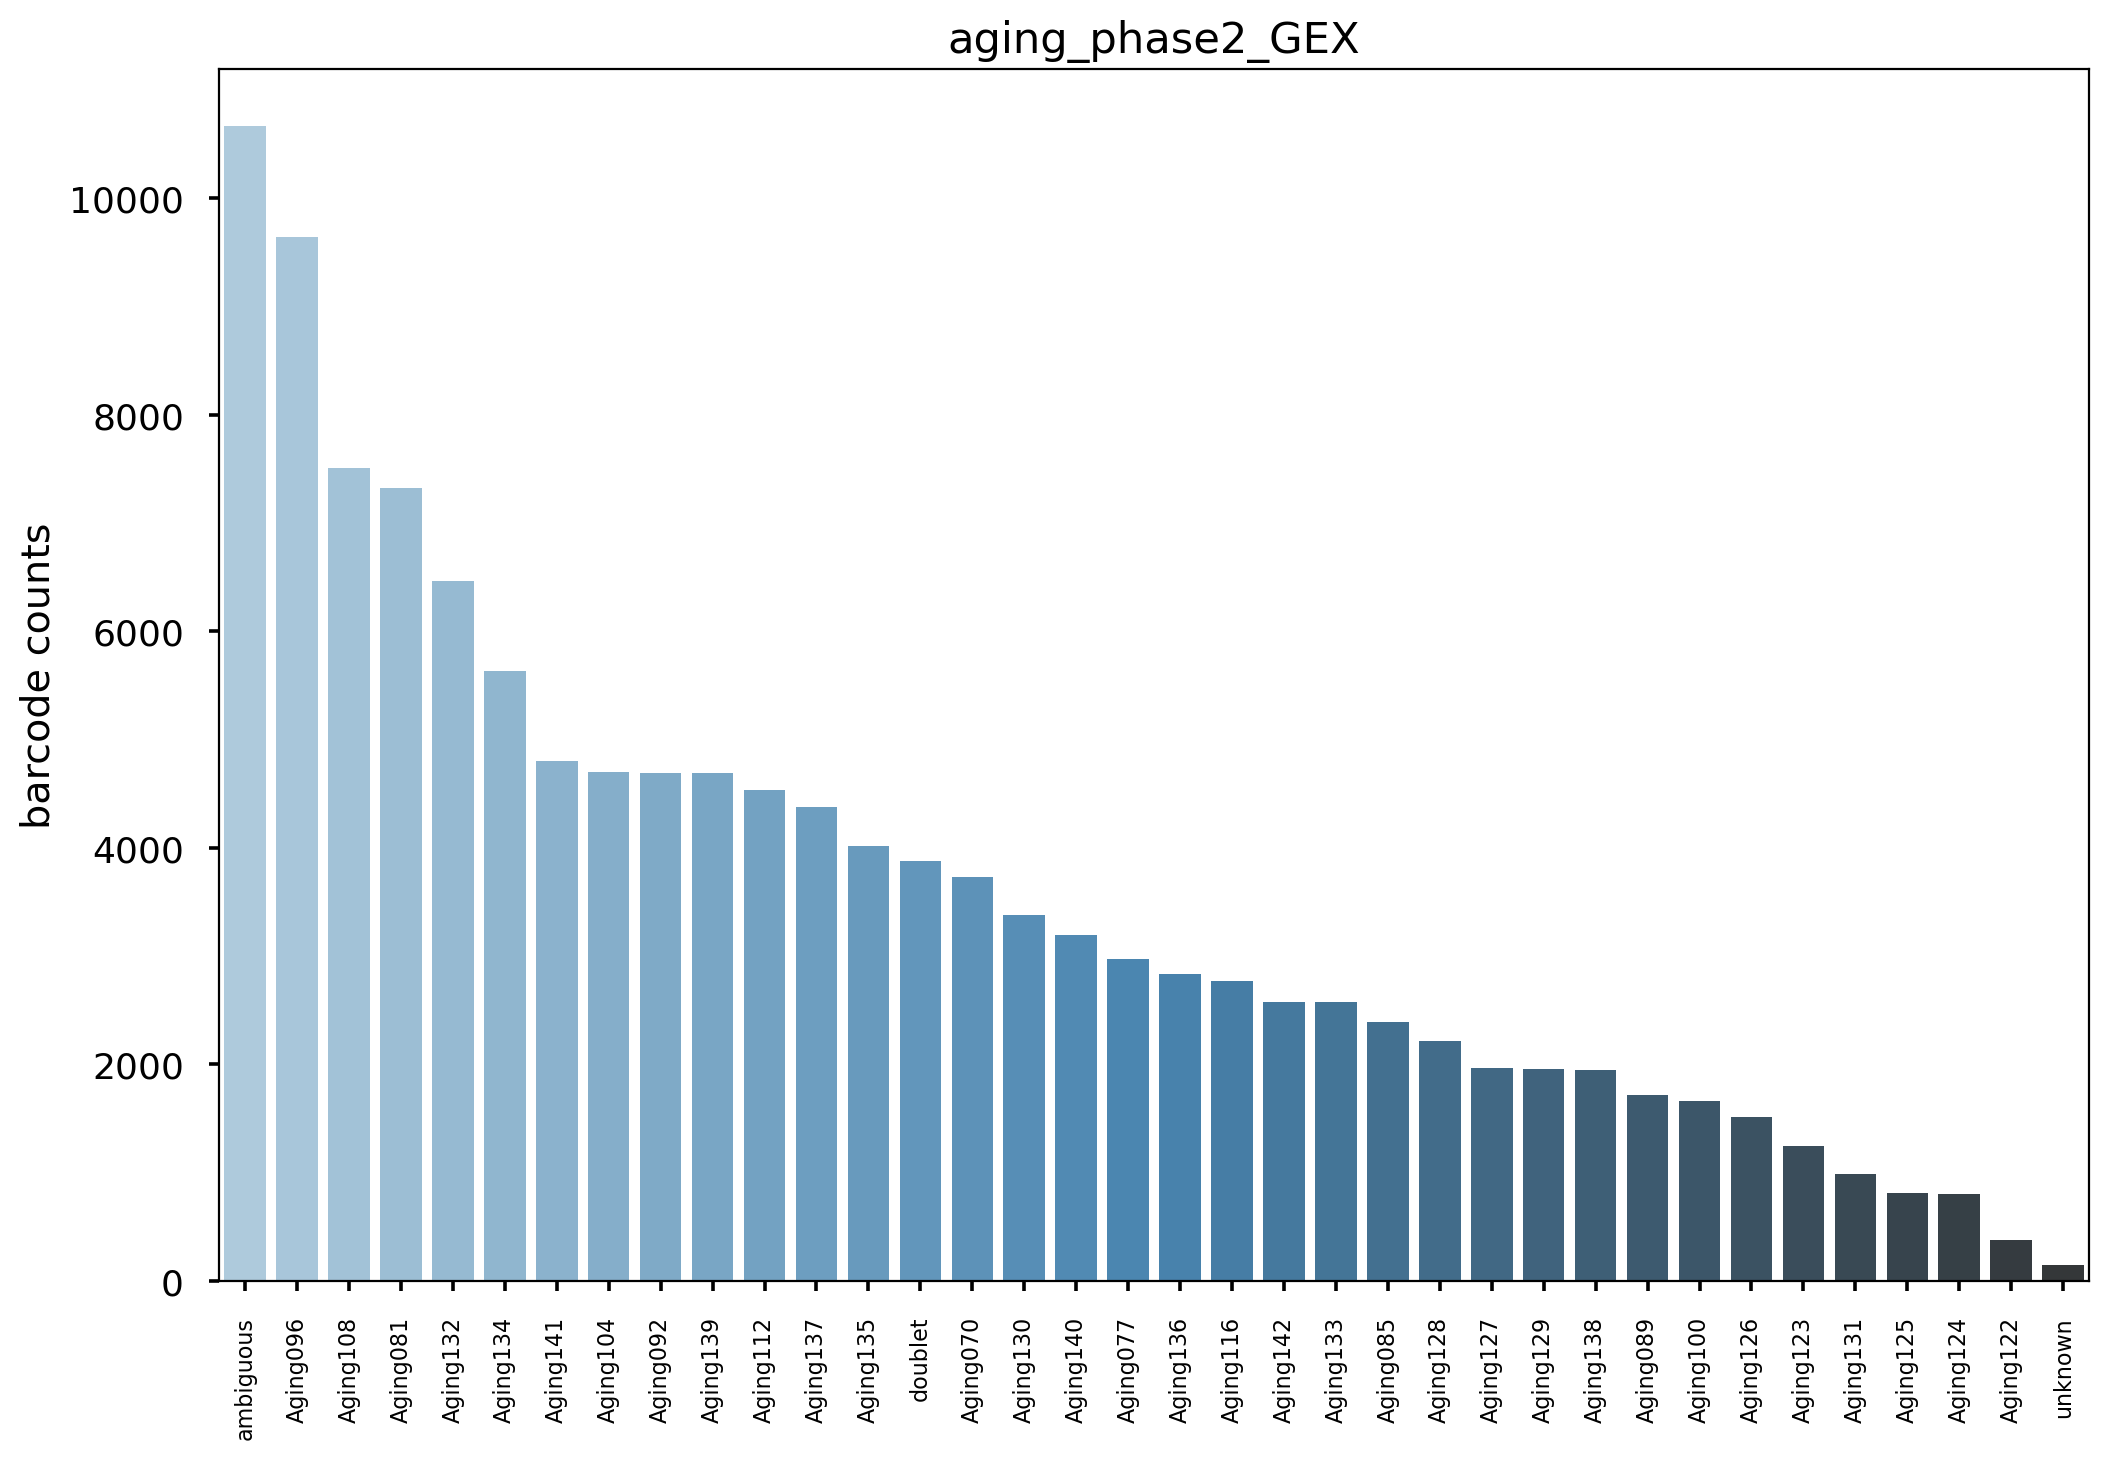

ambiguous    10662
Aging096      9642
Aging108      7510
Aging081      7322
Aging132      6465
Aging134      5635
Aging141      4802
Aging104      4699
Aging092      4689
Aging139      4688
Aging112      4533
Aging137      4381
Aging135      4014
doublet       3882
Aging070      3732
Aging130      3376
Aging140      3195
Aging077      2977
Aging136      2835
Aging116      2771
Aging142      2581
Aging133      2579
Aging085      2391
Aging128      2215
Aging127      1965
Aging129      1958
Aging138      1946
Aging089      1714
Aging100      1666
Aging126      1516
Aging123      1250
Aging131       986
Aging125       811
Aging124       802
Aging122       376
unknown        152
Name: sample_id, dtype: int64


In [9]:
plot_sample_barcode_counts(all_adata.obs, set_name)

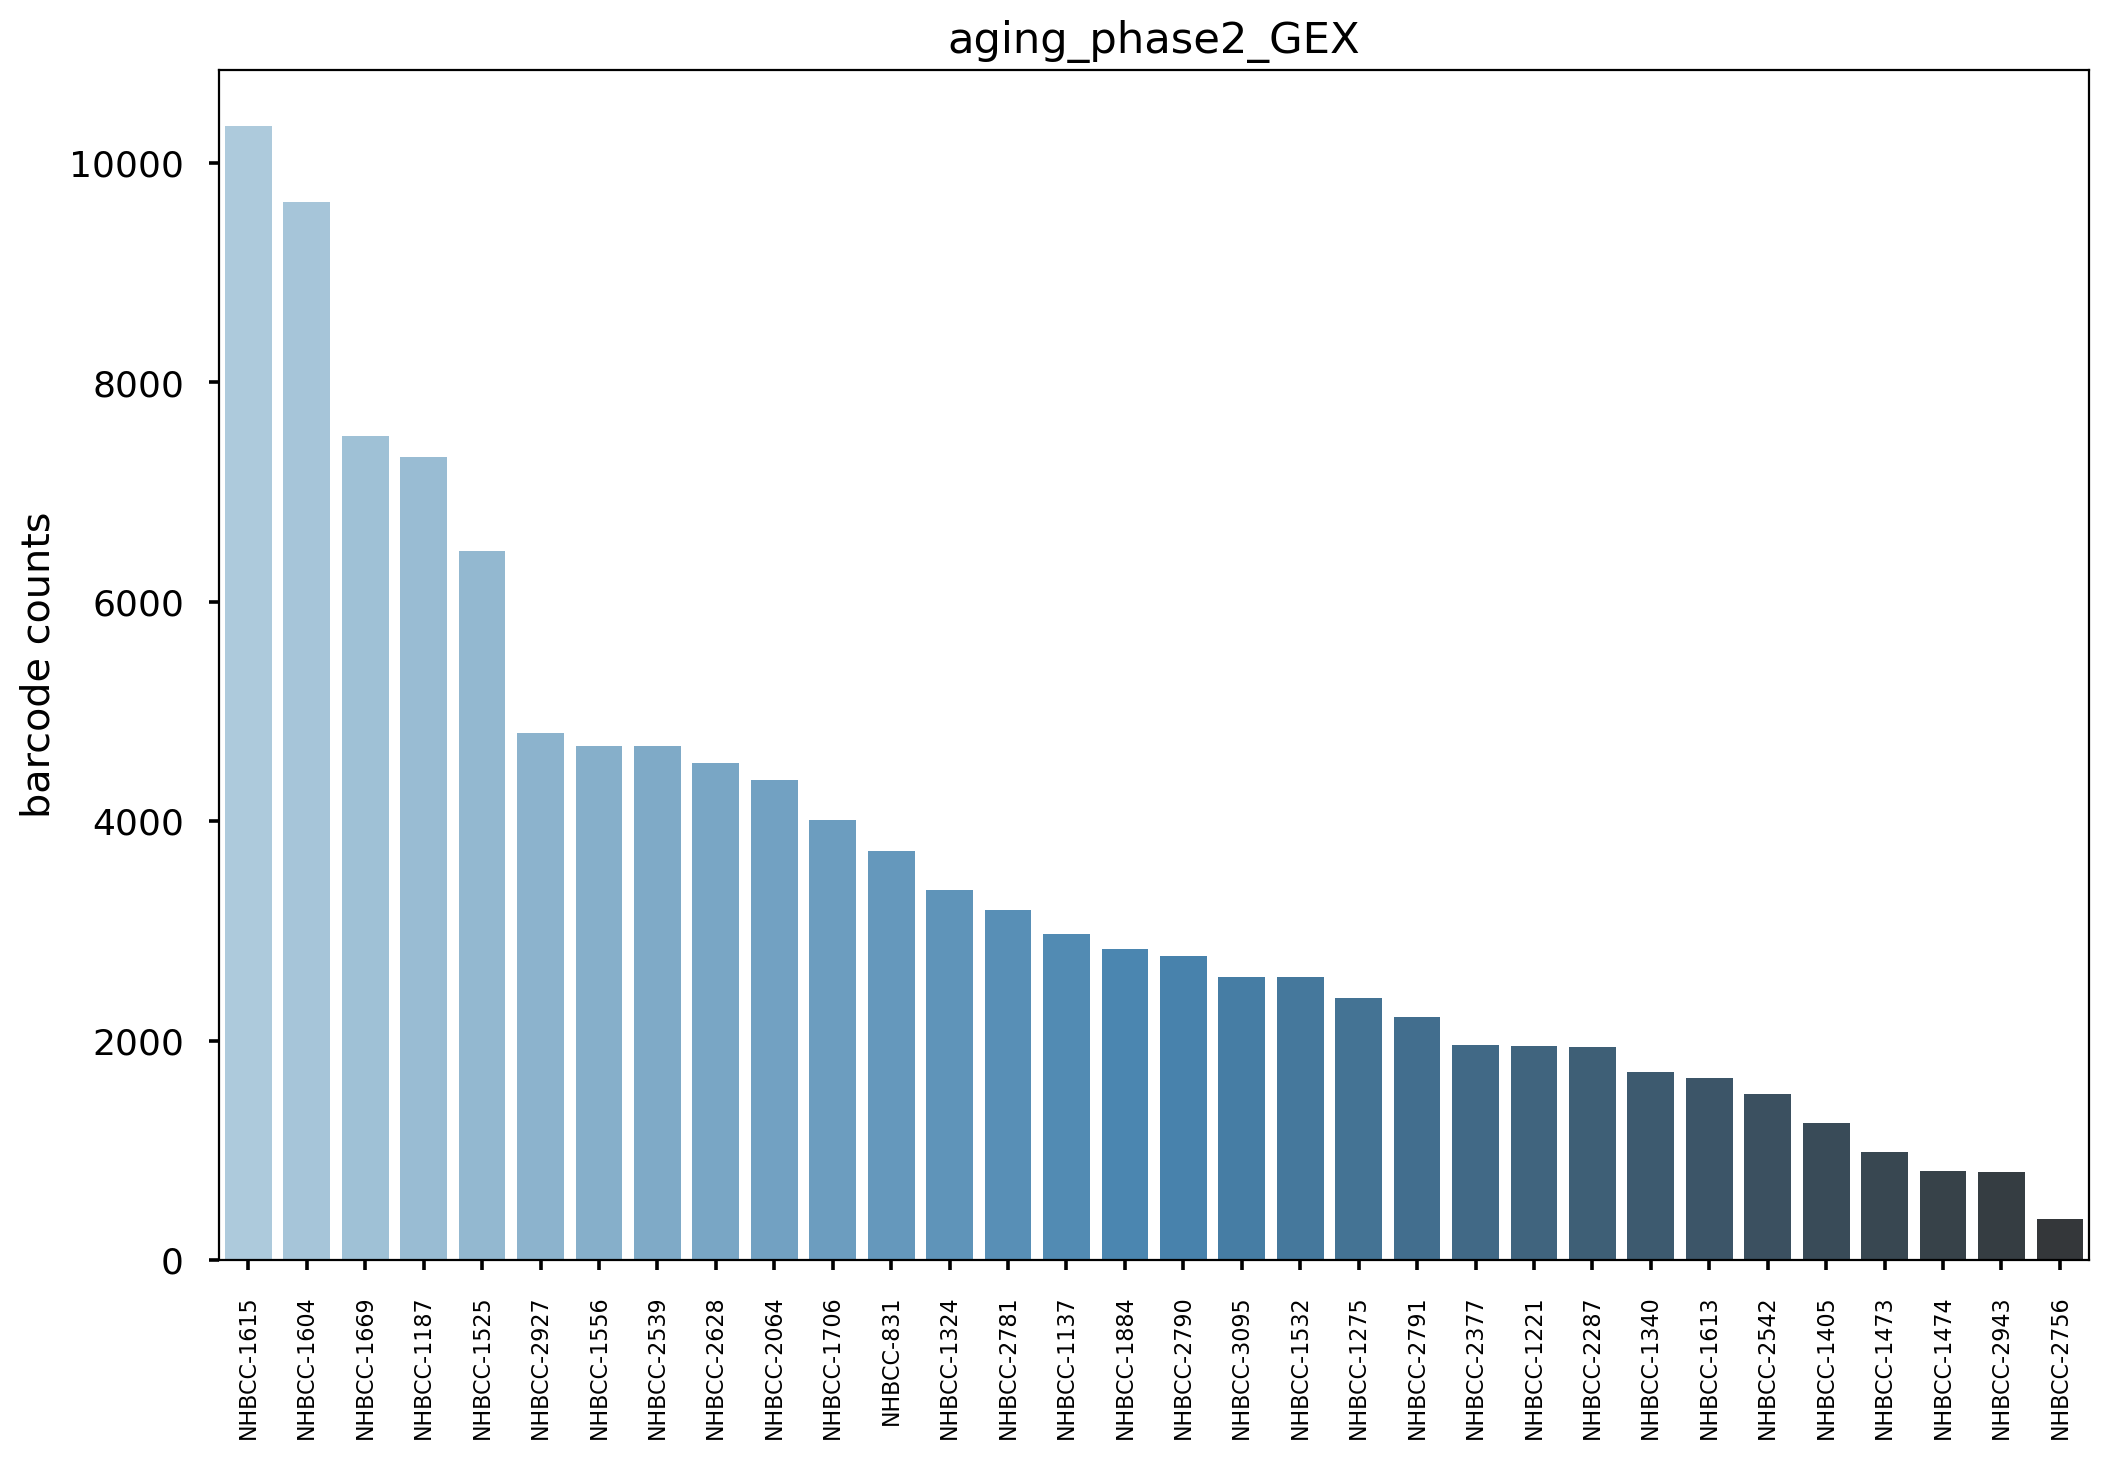

NHBCC-1615    10334
NHBCC-1604     9642
NHBCC-1669     7510
NHBCC-1187     7322
NHBCC-1525     6465
NHBCC-2927     4802
NHBCC-1556     4689
NHBCC-2539     4688
NHBCC-2628     4533
NHBCC-2064     4381
NHBCC-1706     4014
NHBCC-831      3732
NHBCC-1324     3376
NHBCC-2781     3195
NHBCC-1137     2977
NHBCC-1884     2835
NHBCC-2790     2771
NHBCC-3095     2581
NHBCC-1532     2579
NHBCC-1275     2391
NHBCC-2791     2215
NHBCC-2377     1965
NHBCC-1221     1958
NHBCC-2287     1946
NHBCC-1340     1714
NHBCC-1613     1666
NHBCC-2542     1516
NHBCC-1405     1250
NHBCC-1473      986
NHBCC-1474      811
NHBCC-2943      802
NHBCC-2756      376
Name: donor_id, dtype: int64


In [10]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'donor_id')

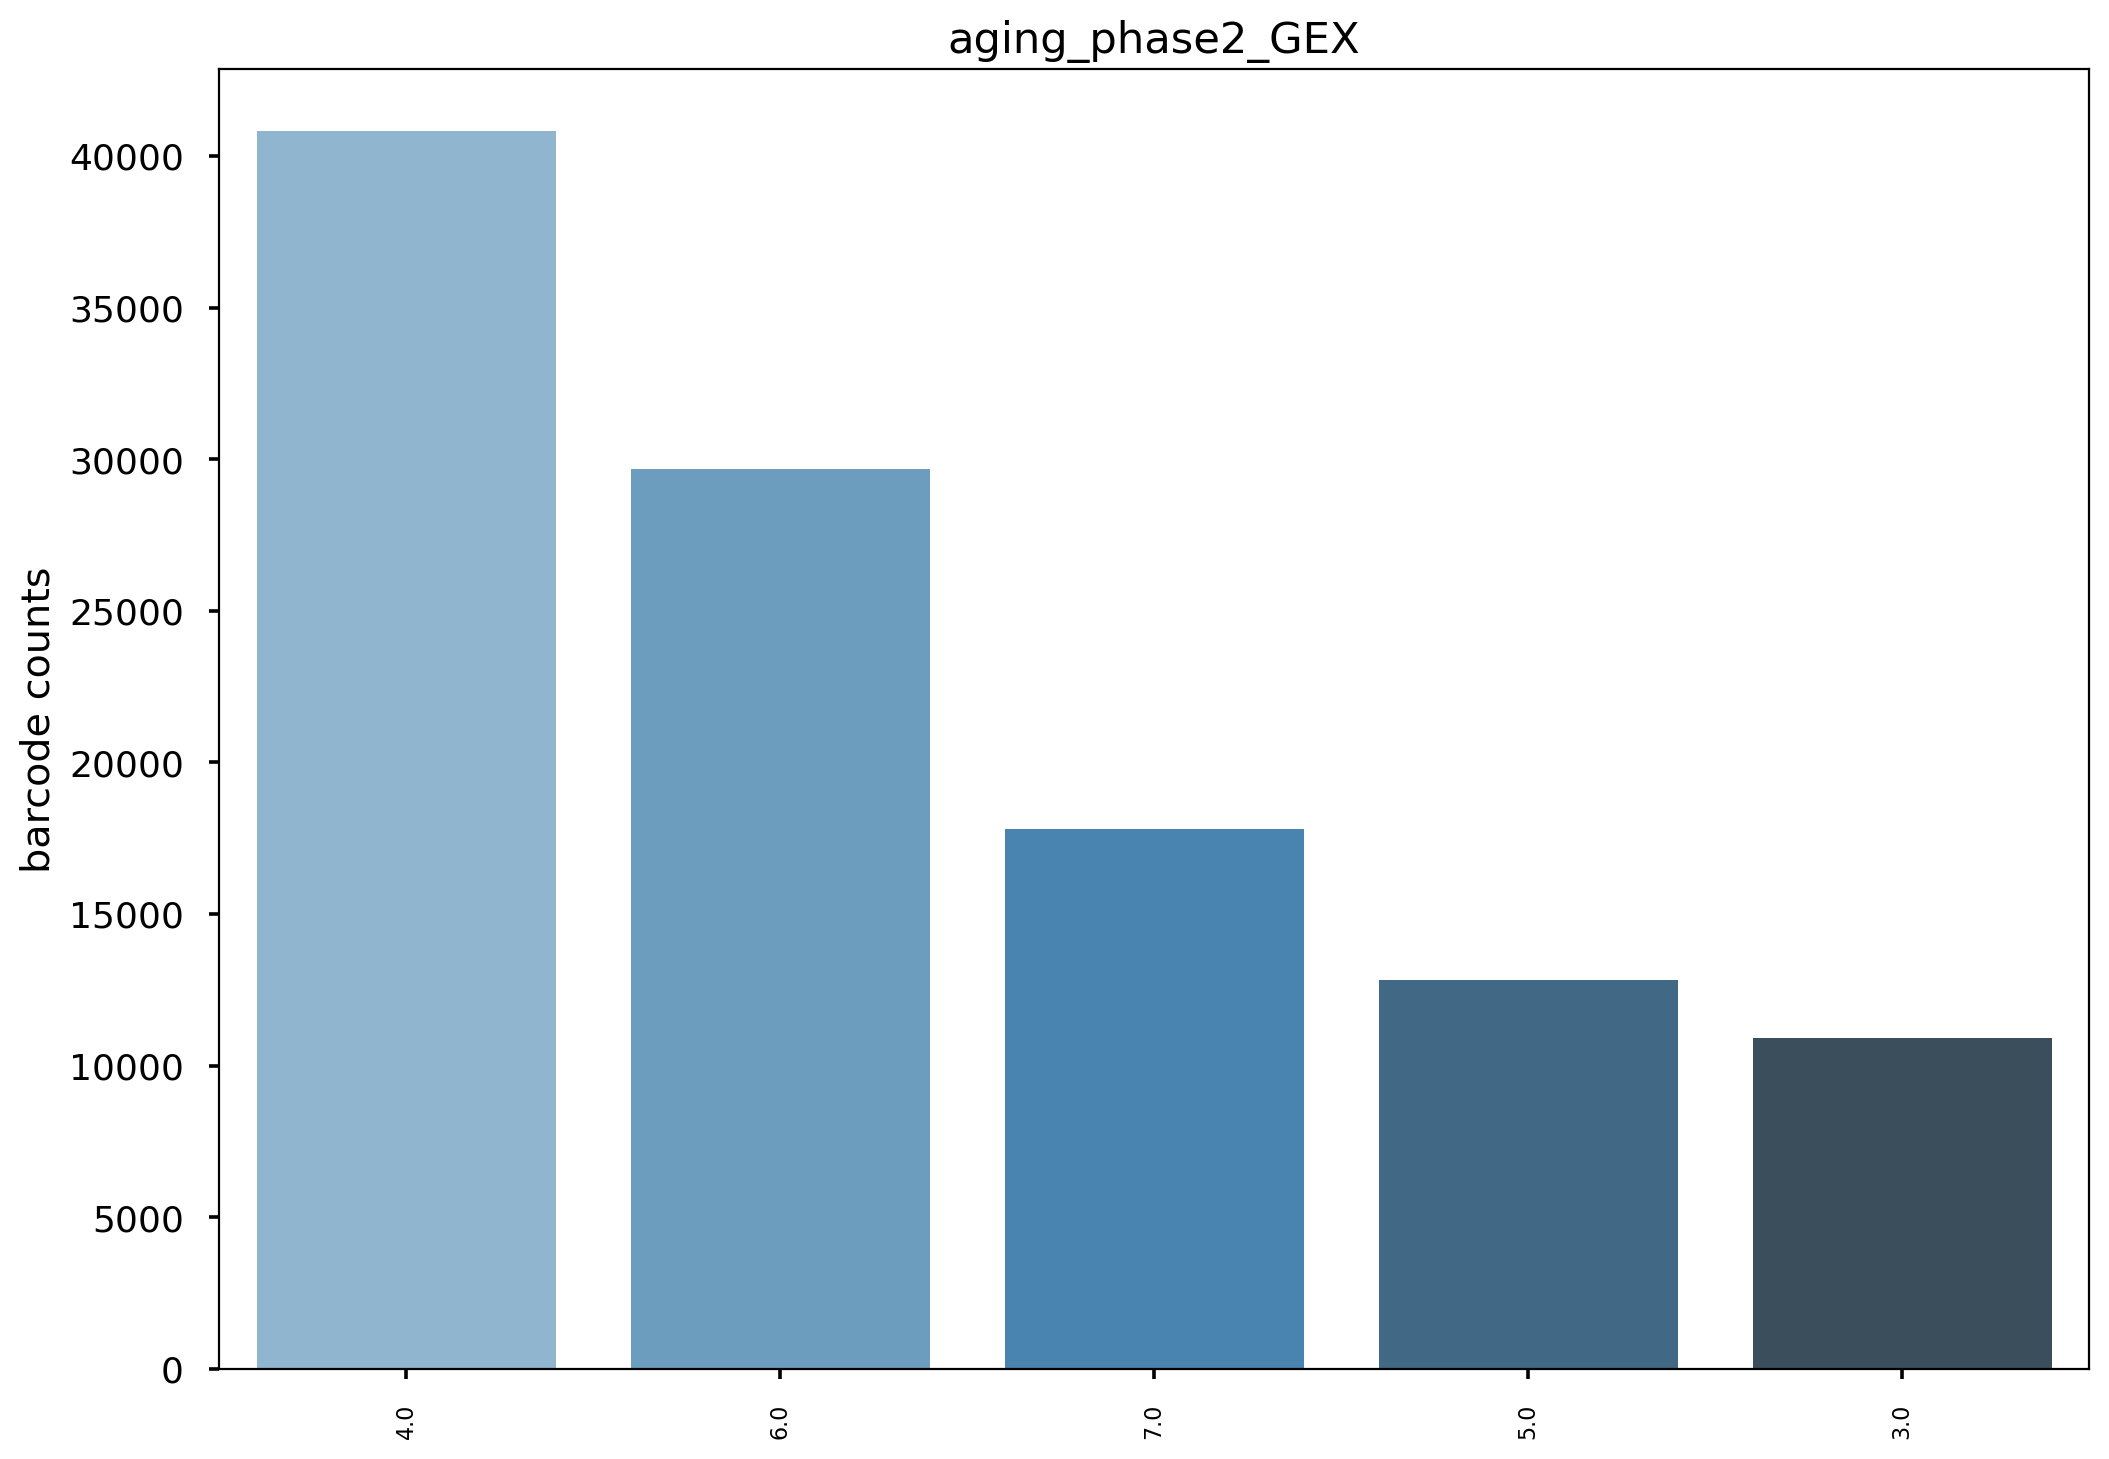

4.0    40818
6.0    29689
7.0    17794
5.0    12828
3.0    10893
Name: gex_pool, dtype: int64


In [11]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'gex_pool')

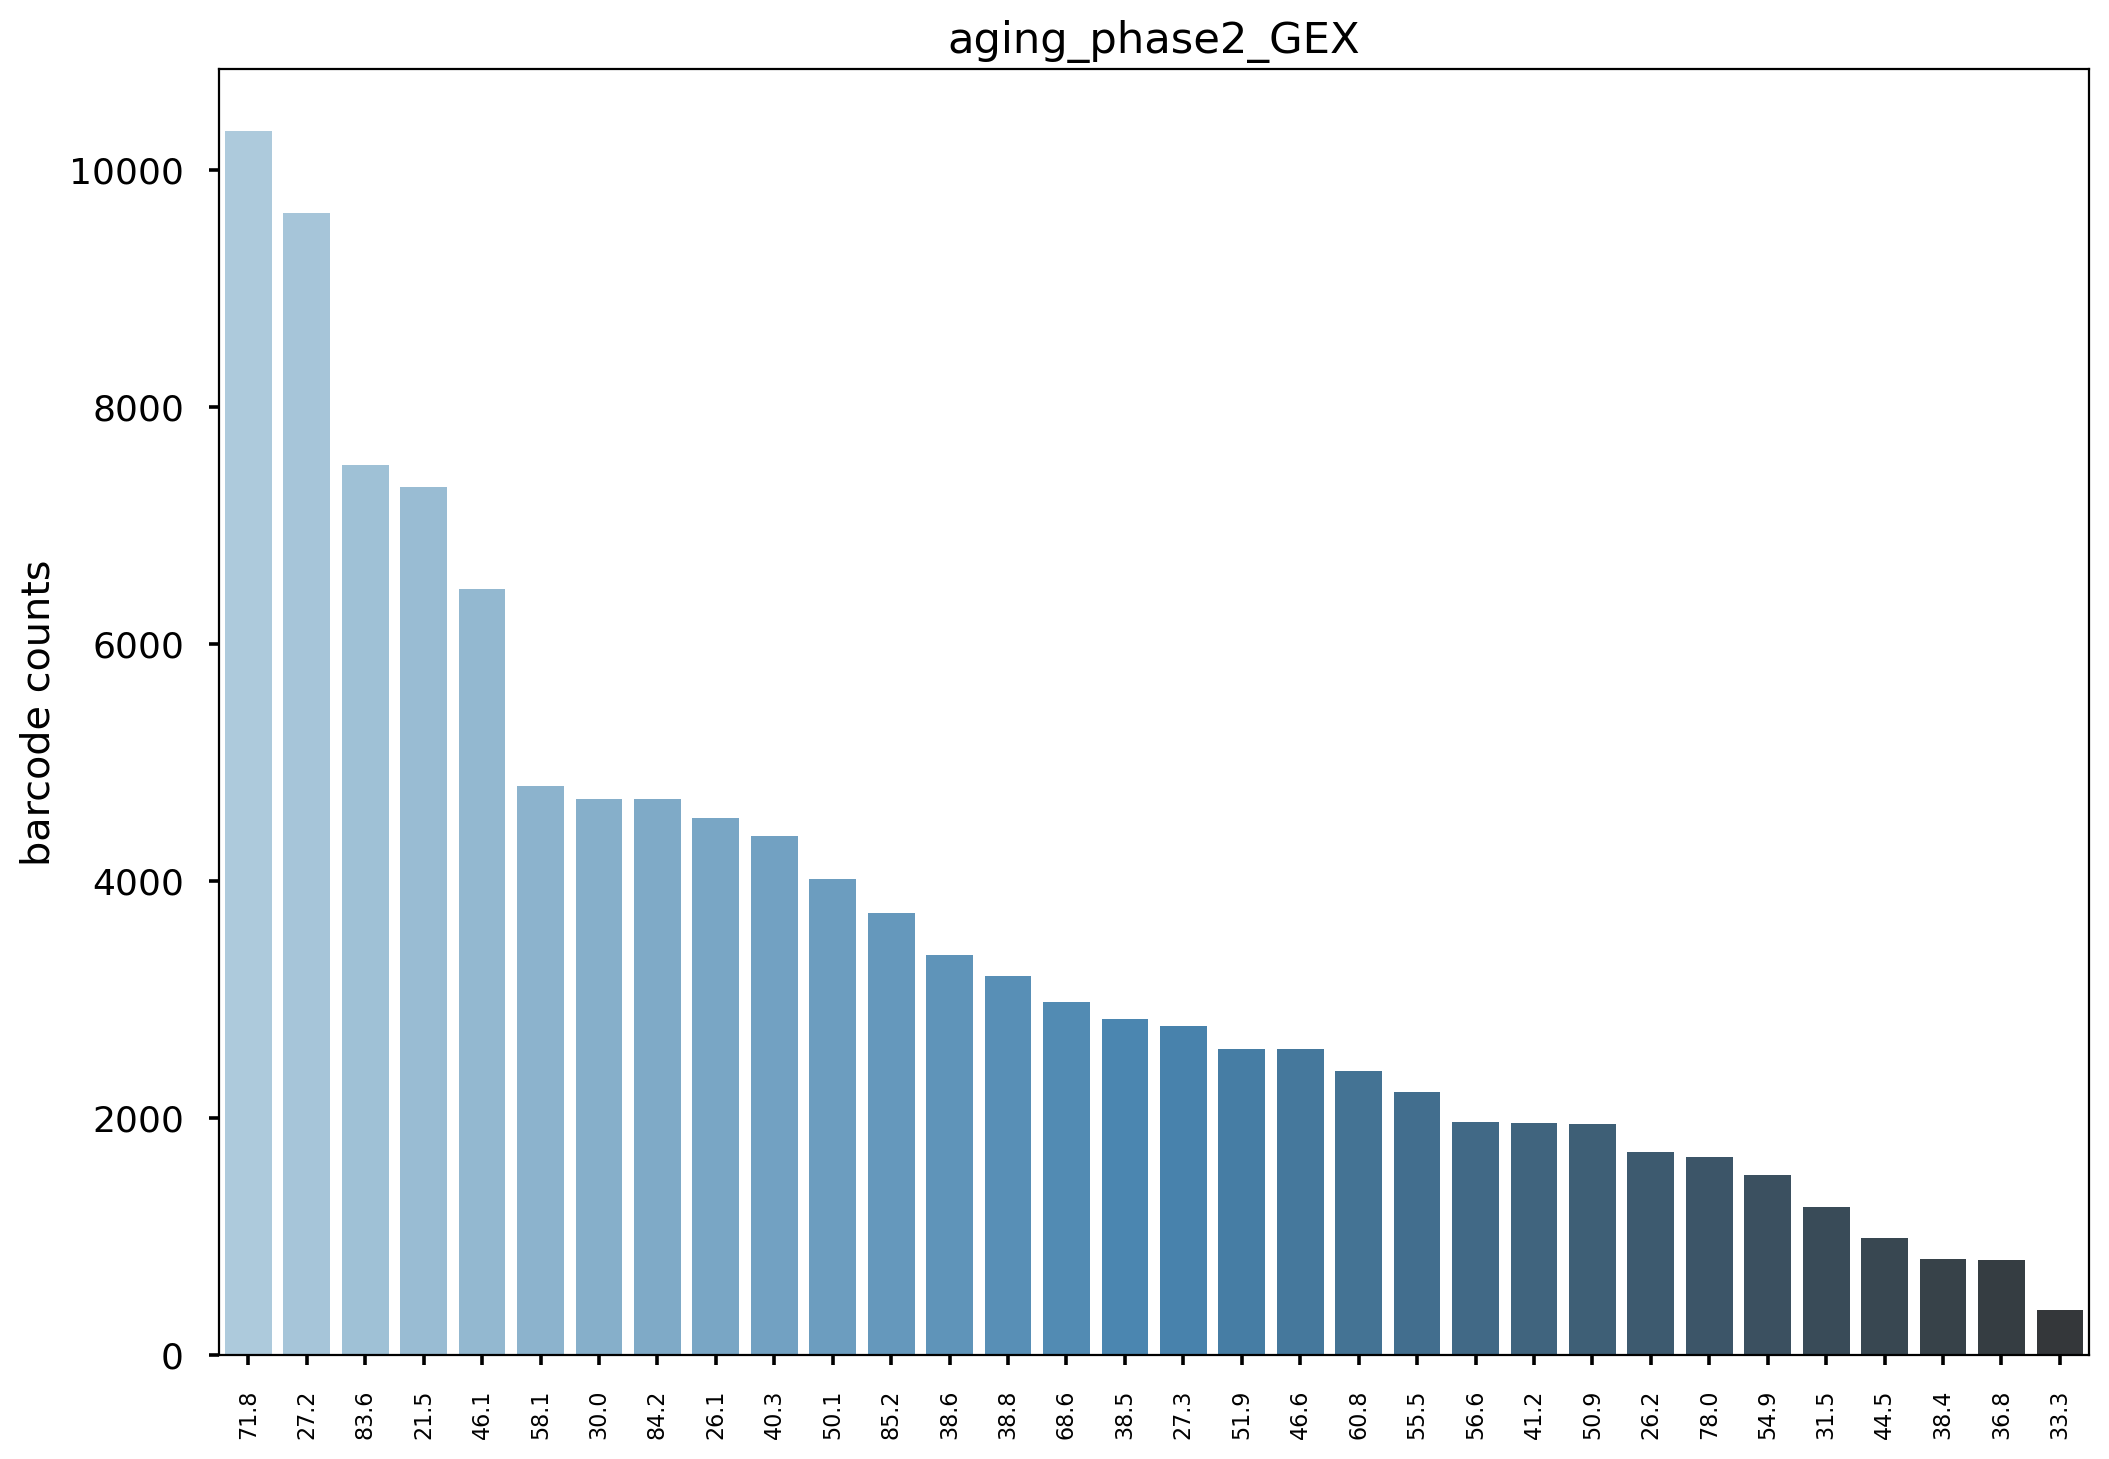

71.8    10334
27.2     9642
83.6     7510
21.5     7322
46.1     6465
58.1     4802
30.0     4689
84.2     4688
26.1     4533
40.3     4381
50.1     4014
85.2     3732
38.6     3376
38.8     3195
68.6     2977
38.5     2835
27.3     2771
51.9     2581
46.6     2579
60.8     2391
55.5     2215
56.6     1965
41.2     1958
50.9     1946
26.2     1714
78.0     1666
54.9     1516
31.5     1250
44.5      986
38.4      811
36.8      802
33.3      376
Name: age, dtype: int64


In [12]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'age')

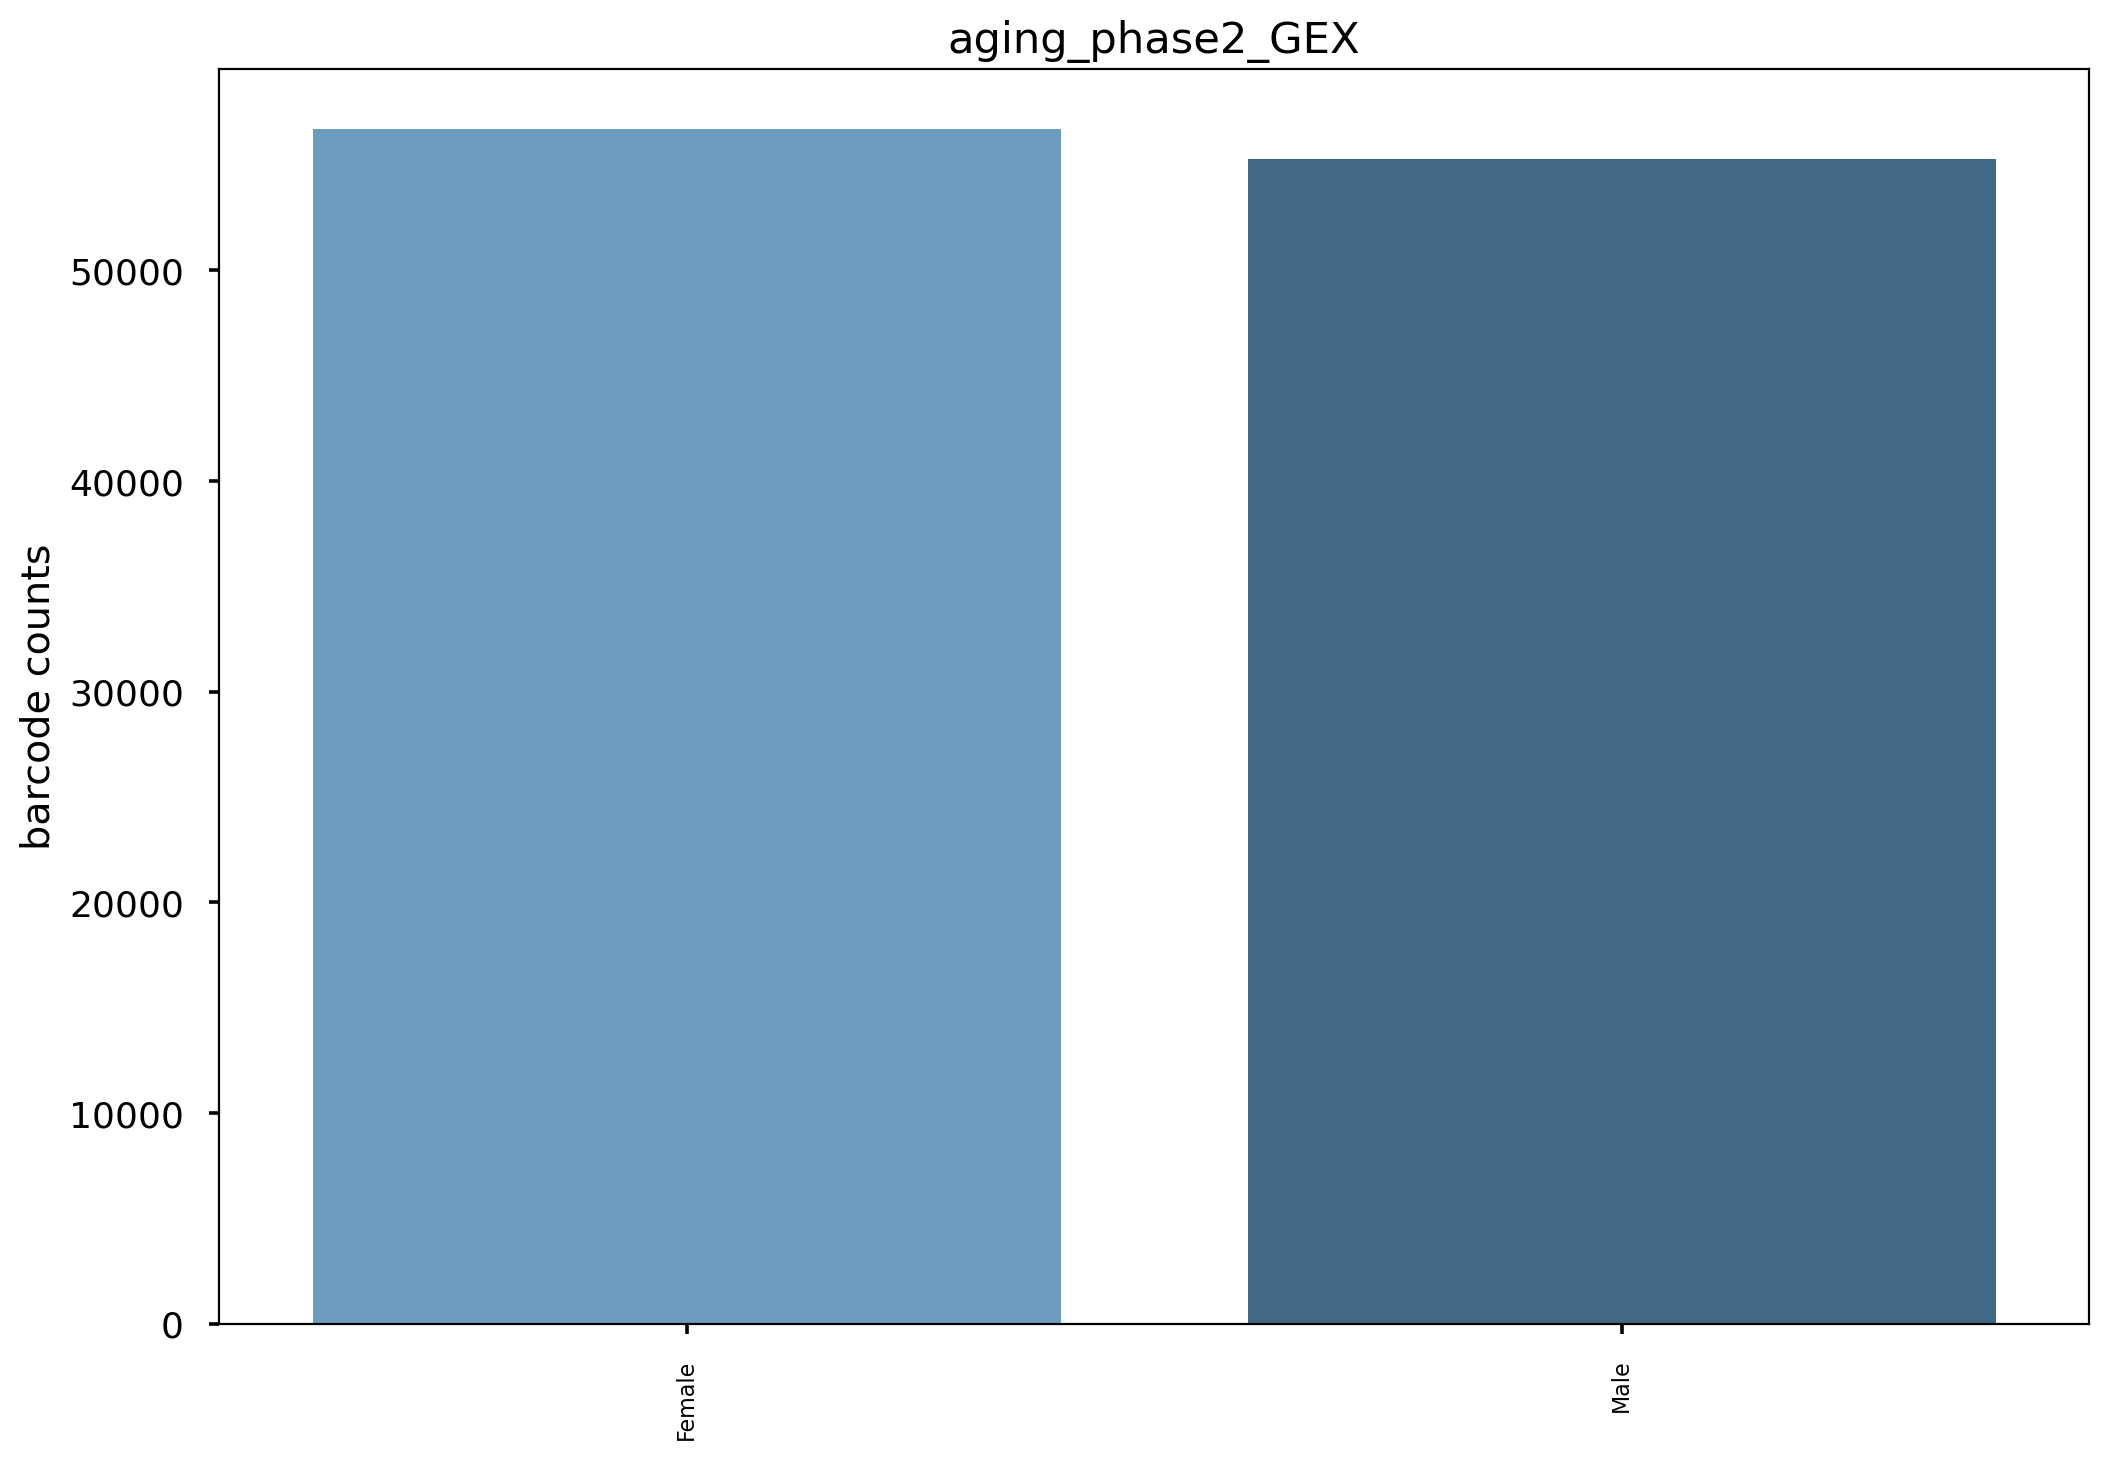

Female    56723
Male      55299
Name: sex, dtype: int64


In [13]:
plot_sample_barcode_counts(all_adata.obs, set_name, 'sex')

In [14]:
!date

Thu Feb 22 15:12:30 EST 2024
